# Imports

In [1]:
from typing import List, Tuple, Optional

import joblib
import openai
from joblib import parallel_config

from burr.core import Application, ApplicationBuilder, Condition, State, action
from burr.core.application import ApplicationContext
from burr.tracking import LocalTrackingClient

# Helper functions

In [2]:
def _query_llm(prompt: str) -> str:
    """Simple wrapper around the OpenAI API."""
    client = openai.Client()
    return (
        client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": "You are a helpful assistant"},
                {"role": "user", "content": prompt},
            ],
        )
        .choices[0]
        .message.content
    )

# Sub Application

First let's write a sub-application. We're going to have it do two things:

1. Write a poem (`write`)
2. Provide suggestions (`edit`)

We're going to wrap its creation in a function so we can create it within an application. Note that we pass in `__context` -- this allows us to wire the context through for tracking.

In [3]:
@action(
    reads=["feedback", "current_draft", "poem_type", "prompt"],
    writes=["current_draft", "draft_history", "num_drafts"],
)
def write(state: State) -> Tuple[dict, State]:
    """Writes a draft of a poem."""
    poem_subject = state["prompt"]
    poem_type = state["poem_type"]
    current_draft = state.get("current_draft")
    feedback = state.get("feedback")

    parts = [
        f'You are an AI poet. Create a {poem_type} poem on the following subject: "{poem_subject}".'
    ]

    if current_draft:
        parts.append(f'Here is the current draft of the poem: "{current_draft}".')

    if feedback:
        parts.append(f'Please incorporate the following feedback: "{feedback}".')

    parts.append(
        f"Ensure the poem is creative, adheres to the style of a {poem_type}, and improves upon the previous draft."
    )

    prompt = "\n".join(parts)

    draft = _query_llm(prompt)

    return {"draft": draft}, state.update(
        current_draft=draft,
        draft_history=state.get("draft_history", []) + [draft],
    ).increment(num_drafts=1)


@action(reads=["current_draft", "poem_type", "prompt"], writes=["feedback"])
def edit(state: State) -> Tuple[dict, State]:
    """Edits a draft of a poem, providing feedback"""
    poem_subject = state["prompt"]
    poem_type = state["poem_type"]
    current_draft = state["current_draft"]

    prompt = f"""
    You are an AI poetry critic. Review the following {poem_type} poem based on the subject: "{poem_subject}".
    Here is the current draft of the poem: "{current_draft}".
    Provide detailed feedback to improve the poem. If the poem is already excellent and needs no changes, simply respond with an empty string.
    """

    feedback = _query_llm(prompt)

    return {"feedback": feedback}, state.update(feedback=feedback)


@action(reads=["current_draft"], writes=["final_draft"])
def final_draft(state: State) -> Tuple[dict, State]:
    return {"final_draft": state["current_draft"]}, state.update(final_draft=state["current_draft"])


def _create_sub_application(
    max_num_drafts: int,
    spawning_application_context: Optional[ApplicationContext],
    poem_type: str,
    prompt: str,
) -> Application:
    """Utility to create sub-application -- note"""
    builder = (
        ApplicationBuilder()
        .with_actions(
            edit,
            write,
            final_draft,
        )
        .with_transitions(
            ("write", "edit", Condition.expr(f"num_drafts < {max_num_drafts}")),
            ("write", "final_draft"),
            ("edit", "final_draft", Condition.expr("len(feedback) == 0")),
            ("edit", "write"),
        )
        .with_entrypoint("write")
        .with_state(
            current_draft=None,
            poem_type=poem_type,
            prompt=prompt,
            feedback=None,
        )
    )
    # so we can run without it
    if spawning_application_context:
        builder=(
            builder
            .with_tracker(spawning_application_context.tracker.copy())  # remember to do `copy()` here!
            .with_spawning_parent(
                spawning_application_context.app_id,
                spawning_application_context.sequence_id,
                spawning_application_context.partition_key,
            )
        )
        
    return builder.build()

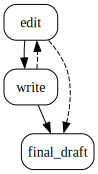

In [4]:
_create_sub_application(2, None, "sonnet", "state machines").visualize()

# Full Application

Next let's create the actual application. We'll call the sub-application inside the `generate_all_poems` step:

In [5]:
# full agent
@action(
    reads=[],
    writes=[
        "max_drafts",
        "poem_types",
        "poem_subject",
    ],
)
def user_input(
    state: State, max_drafts: int, poem_types: List[str], poem_subject: str
) -> Tuple[dict, State]:
    """Collects user input for the poem generation process."""
    return {
        "max_drafts": max_drafts,
        "poem_types": poem_types,
        "poem_subject": poem_subject,
    }, state.update(max_drafts=max_drafts, poem_types=poem_types, poem_subject=poem_subject)


@action(reads=["max_drafts", "poem_types", "poem_subject"], writes=["proposals"])
def generate_all_poems(state: State, __context: ApplicationContext) -> Tuple[dict, State]:
    # create one each
    apps = [
        _create_sub_application(state["max_drafts"], __context, poem_type, state["poem_subject"])
        for poem_type in state["poem_types"]
    ]
    # run them all in parallel
    with parallel_config(backend="threading", n_jobs=3):
        all_results = joblib.Parallel()(
            joblib.delayed(app.run)(halt_after=["final_draft"])
            for app, poem_type in zip(apps, state["poem_types"])
        )
    proposals = []
    for *_, substate in all_results:
        proposals.append(substate["final_draft"])

    return {"proposals": proposals}, state.update(proposals=proposals)


@action(reads=["proposals", "prompts"], writes=["final_results"])
def final_results(state: State) -> Tuple[dict, State]:
    # joins them into a string
    proposals = state["proposals"]
    final_results = "\n\n".join(
        [f"{poem_type}:\n{proposal}" for poem_type, proposal in zip(state["poem_types"], proposals)]
    )
    return {"final_results": final_results}, state.update(final_results=final_results)

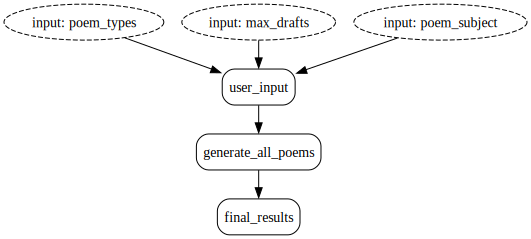

In [6]:
app = (
    ApplicationBuilder()
    .with_actions(
        user_input,
        generate_all_poems,
        final_results,
    )
    .with_transitions(
        ("user_input", "generate_all_poems"),
        ("generate_all_poems", "final_results"),
    )
    .with_tracker(project="demo:parallelism_poem_generation")
    .with_entrypoint("user_input")
    .build()
)
app.visualize()

In [19]:
from IPython.display import Markdown
Markdown(f"[View in UI!](http://localhost:7241/project/demo:parallelism_poem_generation/{app.uid}) (make sure Burr is running first)")

[View in UI!](http://localhost:7241/project/demo:parallelism_poem_generation/7e4abaa5-5d9f-4a35-863b-9627727eb4d4) (make sure Burr is running first)

# Running it

In [7]:
action, state, results = app.run(
    halt_after=["final_results"],
    inputs={
        "max_drafts": 2,
        "poem_types": [
            "sonnet",
            "limerick",
            "haiku",
            "acrostic",
        ],
        "poem_subject": "state machines",
    },
)

In [12]:
print(results['final_results'])

sonnet:
In realms of logic, where machines reside,
With gears of reason, wheels of choice aligned,
A state machine, our guiding technologic guide,
A dance of code within a frame confined.

It starts with states, finite list well-traced,
Transitions chart its routes from here to there.
Encoded paths, in logic's arms embraced,
A web of rules, spun tight with utmost care.

From idle calm to busy hum it shifts,
With each condition met, it alters course.
It thrives on change; its power deftly lifts,
Transforms through states, a tireless, coded force.

Though hardware cold may cloak its silent might,
In structured change, it brings our world to light.

limerick:
In realms where the data aligns,
Live machines with sleek, stateful designs.
Their transitions, so neat,
Make logic a treat,
As grand as the royals in lines.

haiku:
Whispers of logic,
Circuits pulse in silent paths —
States craft vivid tales.

acrostic:
**State Machines**

**S**hadows of logic in code’s tight embrace,
**T**houghts i